## Classificador de SMILE y NON-SMILE utilizando CNN

1) Primero caragamos las librerías que utilizaremos mas adelante

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model

from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix, classification_report

2) En este código lo que haremos es cargar las base de datos la cual son las imagenes en formato .ppm (Portable Pixmap Format, un formato de archivo de imagen sin comprimir y sencillo).

Primero definimos la ruta en la cual estan las imagenes es que es en la carpeta /faces y los archivos que contienen las etiquetas (SMILE_list.txt y NONSMILE_list.txt)

Al leer los dos archivos de las etiqueta, el cual contiene los nombres de las personas que estan sonriendo y los que no. Asi mismo eliminamos los espacios en blanco y saltos de línea para asegurar que los nombres estén correctamente formateados-

Finalmente, se recorren las listas de nombres de imágenes, se ajusta la extensión de .jpg a .ppm (ya que las imágenes en LFWcrop están almacenadas en formato PPM), y se cargan efectivamente las imágenes existentes. Cada imagen se almacena en features, mientras que sus etiquetas correspondientes (“smile” o “non-smile”) se almacenan en labels.



In [ ]:
import os
import numpy as np
from PIL import Image

FACES_DIR = "faces"
SMILE_LIST = "lists/SMILE_list.txt"
NONSMILE_LIST = "lists/NON-SMILE_list.txt"


with open(SMILE_LIST, "r") as f:
    smile_files = [line.strip() for line in f if line.strip() != ""]

with open(NONSMILE_LIST, "r") as f:
    nonsmile_files = [line.strip() for line in f if line.strip() != ""]

print("Ejemplos SMILE_list:", smile_files[:5])
print("Ejemplos NONSMILE_list:", nonsmile_files[:5])


def safe_load(path):
    try:
        return np.array(Image.open(path)) / 255.0
    except Exception as e:
        print(f"⚠️ Error leyendo {path}: {e}")
        return None


X = []
y = []

for fname in smile_files:
    ppm_name = fname.replace(".jpg", ".ppm")  
    path = os.path.join(FACES_DIR, ppm_name)
    if os.path.exists(path):
        img = safe_load(path)
        if img is not None:
            X.append(img)
            y.append("smile")
    else:
        print("No existe:", path)

for fname in nonsmile_files:
    ppm_name = fname.replace(".jpg", ".ppm")  
    path = os.path.join(FACES_DIR, ppm_name)
    if os.path.exists(path):
        img = safe_load(path)
        if img is not None:
            X.append(img)
            y.append("non-smile")
    else:
        print("No existe:", path)

features = np.array(X)
labels = np.array(y)

print("features shape:", features.shape)
print("labels shape:", labels.shape)

Ejemplos SMILE_list: ['James_Jones_0001.jpg', 'James_Kelly_0009.jpg', 'James_McPherson_0001.jpg', 'James_Watt_0001.jpg', 'Jamie_Carey_0001.jpg']
Ejemplos NONSMILE_list: ['Aaron_Eckhart_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Abdel_Nasser_Assidi_0002.jpg', 'Abdoulaye_Wade_0004.jpg', 'Abdulaziz_Kamilov_0001.jpg']
No existe: faces\listt.txt
No existe: faces\SMILE_list.txt
features shape: (1203, 64, 64, 3)
labels shape: (1203,)


3) Confirmando que el código pasado fue exitoso vemos las primeras 5 filas de smile y nonsmile

In [142]:
print("Ejemplos SMILE_list:", smile_files[:5])
print("Ejemplos NONSMILE_list:", nonsmile_files[:5])


Ejemplos SMILE_list: ['James_Jones_0001.jpg', 'James_Kelly_0009.jpg', 'James_McPherson_0001.jpg', 'James_Watt_0001.jpg', 'Jamie_Carey_0001.jpg']
Ejemplos NONSMILE_list: ['Aaron_Eckhart_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Abdel_Nasser_Assidi_0002.jpg', 'Abdoulaye_Wade_0004.jpg', 'Abdulaziz_Kamilov_0001.jpg']


4) Queremos ver la dimesion de cada una de las listas

Labels: Dice si es smile o nonsmile

Features: Las features de las imagenes

In [143]:
print(labels.shape)
print(features.shape)

(1203,)
(1203, 64, 64, 3)


5) Aquí encodearemos las variables esto para la CNN, hacemos el texto de smile a 1 y nonsmile a 0.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

labels_int = le.fit_transform(labels.ravel())

Vemos que si haya funcionado

In [145]:
print(labels[0])
print(labels_int[0])

smile
1


Aqui las hacemos categóricas 

In [146]:
labels = tf.keras.utils.to_categorical(labels_int, num_classes = 2)

5) Con la función de train_test_split dividimos nuestros datos para entrenarlos y testearlos. Para el train agarramos el 80 % de los datos y para el test el restante. 

In [147]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_int, test_size=0.2, random_state=42)

Checamos que la dimensionalidad correcta.

In [148]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(962, 64, 64, 3)
(962,)
(241, 64, 64, 3)
(241,)


In [149]:
print(y_train[:10])

[0 1 1 1 1 0 0 1 1 0]


6) Aquí ya creamos nuesta CNN, el cual nuestra input va a ser las dimesiones de las imagenes originales. 

 Y nuestra output va aser 2 clases que sera si smile o nonsmile

In [ ]:
dropout_rate = 0.5

inputs = Input(shape=(64,64,3)) 

conv1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)

mp1 = MaxPooling2D(pool_size=(2, 2))(conv1) 

conv2 = Conv2D(filters=24, kernel_size=(3,3), activation='relu')(mp1)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

flat = Flatten()(pool2)

hidden1 = Dense(units=128, activation='relu')(flat)

dropHidden1 = Dropout(rate=dropout_rate)(hidden1)

output = Dense(units=2, activation='softmax')(dropHidden1)

model = Model(inputs=inputs, outputs=output)

In [151]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 29, 29, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       602,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,426 (2.31 MB)

 Trainable params: 606,426 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

7) El modelo se compila utilizando sparse_categorical_crossentropy como función de pérdida, el optimizador SGD con tasa de aprendizaje 0.01 y la métrica de exactitud. Posteriormente, se entrena durante 100 épocas con un tamaño de batch de 16, reservando el 20% de los datos de entrenamiento para validación.

El historial del entrenamiento (loss y accuracy) se almacena en la variable history.

In [152]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4928 - loss: 0.6949 - val_accuracy: 0.4352 - val_loss: 0.7095
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5618 - loss: 0.6810 - val_accuracy: 0.5648 - val_loss: 0.6705
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6060 - loss: 0.6727 - val_accuracy: 0.5648 - val_loss: 0.6661
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6619 - loss: 0.6523 - val_accuracy: 0.5751 - val_loss: 0.6419
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6840 - loss: 0.6310 - val_accuracy: 0.4352 - val_loss: 0.7535
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7048 - loss: 0.6166 - val_accuracy: 0.5907 - val_loss: 0.6219
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7386 - loss: 0.5552 - val_accuracy: 0.6373 - val_loss: 0.5876
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7646 - loss: 0.5220 - val_accuracy: 0.8083 - 

8) Gráficas para ver como se comporta el accuracy y el loss

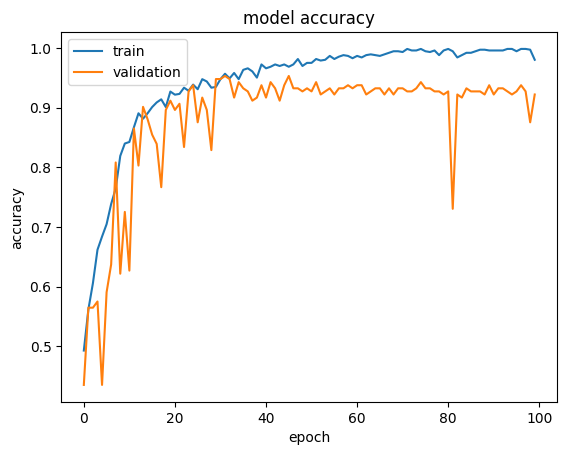

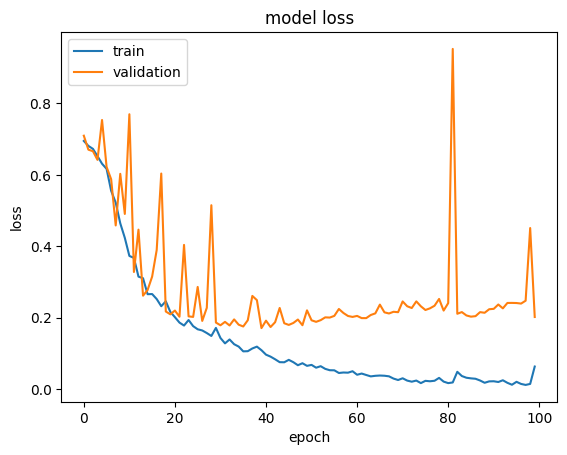

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

9) Aquí evaluamos el modelo con los datos de testeo

Esto al final nos arrojará el accuracy de nuestro modelo.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9253 - loss: 0.2246 
Test accuracy: 0.9253112077713013


10) Ahora para ver todas las métricas de nuestro modelo utilizaremos la función .predict

In [158]:
predictions = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
print(predictions.shape)

(241, 2)


11) Para poder hacer la transformación inversa para hacer la confusion matrix con las palabras de smile y nonsmile, hacemos el siguiente codigo el cual agarra el argumento maximo de las predicciones. 

In [168]:
y_pred_int = np.argmax(predictions, axis=1) 
print("Shape y_pred_int:", y_pred_int.shape)

Shape y_pred_int: (241,)


Aquí ya lo invertimos para que nos diga en texto las predicciones

In [170]:
y_pred_labels = le.inverse_transform(y_pred_int)
y_test_labels = le.inverse_transform(y_test)
print("Ejemplos y_test_labels:", y_test_labels[:5])
print("Ejemplos y_pred_labels:", y_pred_labels[:5])


Ejemplos y_test_labels: ['non-smile' 'smile' 'smile' 'non-smile' 'smile']
Ejemplos y_pred_labels: ['non-smile' 'smile' 'smile' 'non-smile' 'non-smile']


Y con las variables pasadas podemos crear la matriz de confusión.

In [171]:
pd.crosstab(y_test_labels, y_pred_labels, rownames=['True labels'], colnames=['Predicted labels'])

Predicted labels,non-smile,smile
True labels,,
non-smile,109,7
smile,11,114


Con la función de classification_report nos automáticamente las métricas de precision, recall y f1-score.

Con esto ya acabamos nuestro primer modelo de clasificación. 

In [174]:
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   non-smile       0.91      0.94      0.92       116
       smile       0.94      0.91      0.93       125

    accuracy                           0.93       241
   macro avg       0.93      0.93      0.93       241
weighted avg       0.93      0.93      0.93       241

